## Borough pairing between Toronto and NYC

### Introduction of the project

__Due to the increasing interactions among big cities in North America and also the increasing restrictions on H1B for foreign workers. It seems to be increasingly popular to relocate, or to expand businesses in different areas. So in this project, we aim to provide some information for people who would like to relocate between Toronto and New York, both as the financial center of Canada and US, by determine what are the best pairing boroughs in Toronto and New York. This analysis on the similarity of two boroughs of the two cities should should benefit the following people:__  

+ working class who'd like to relocate, to find the best area for living/work  

+ business people: better make decisions in terms of store selection when making expansion plans  

+ any city dwellers who are willing to exploring the simiar community in the other city

### Data

__In general, data leveraged in this project come from 3 sources:__  
+ Venue information, including store name/ geographic coordinates and venue categories with access to Foursquare API
+ Borough and neighborhood data of the two cities, with geographical coordinates information
+ Webscrapped demographics from Wikipedia, link below  

[https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods]  

[https://en.wikipedia.org/wiki/Demographics_of_New_York_City]

## Methodology

__After getting the venue data for all the neighborhoods, we aggregated it at borough level and take the frequency of each of the venue. Wtih data transformation and visualization using Word cloud, we were able to determine the most significant and common venues in both cities and take the frequency of these common venues, along with demographic information as the input features to calculate the Euclidean Distances for each pair and determine the match with smallest distance.__

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import requests
import lxml.html as lh
import requests
from bs4 import BeautifulSoup as bs

In [2]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [3]:
neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
NY_Borough = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NY_Borough = NY_Borough.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [4]:
NY_Borough.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html = requests.get(url).text
soup = bs(html, 'html.parser')
ta=soup.find_all('table',{'class':'wikitable'})
df = pd.read_html(str(ta))
df1= df[0]
df1 = df1[df1['Borough']!='Not assigned']
df1['Neighborhood'].isna().sum()
geocode = pd.read_csv("Geospatial_Coordinates.csv")
Toronto_borough = pd.merge(df1,geocode,on='Postal Code')

In [6]:
Borough_list = ['North York', 'Downtown Toronto', 'East York', 'York', 'Etobicoke',
       'Scarborough', 'East Toronto', 'West Toronto', 'Central Toronto',
       'Mississauga'] 
FM_list = ['NY','OCoT','EY','Y','E','S','OCoT','OCoT','OCoT','None']
d = {'Borough':Borough_list,'FM_list':FM_list}
link = pd.DataFrame(d)
Toronto_borough = Toronto_borough.merge(link,how='inner',on = "Borough")

## Get demogrpahics: population / land area / average income

### Toronto demographics with income convered to USD (1CAD = 0.73USD)

In [7]:
url = "https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods"
html = requests.get(url).text
soup = bs(html, 'html.parser')
ta=soup.find_all('table',{'class':'wikitable'}) 
df = pd.read_html(str(ta))
demo_Toronto= df[0][['Name','FM','Population','Land area (km2)','Average Income']][1:]
demo_Toronto["Total_income"] = demo_Toronto['Population']*demo_Toronto['Average Income']
demo_Toronto = demo_Toronto.groupby('FM')['Population','Land area (km2)','Total_income'].sum().reset_index()
demo_Toronto['avg_income_USD'] = (demo_Toronto["Total_income"]/demo_Toronto['Population'])*0.73

### New York demographics

In [8]:
url = "https://en.wikipedia.org/wiki/Demographics_of_New_York_City"
html = requests.get(url).text
soup = bs(html, 'html.parser')
ta=soup.find_all('table',{'class':'wikitable'})[0]
df = pd.read_html(str(ta))
demo_NY= df[0]
demo_NY.columns = demo_NY.columns.droplevel().droplevel()
demo_NY.rename(columns={'Estimate (2019)[12]':'Population',"squarekm":'Land area (km2)'},inplace = True)
demo_NY = demo_NY[['Borough','Population','Land area (km2)']][0:5]

In [9]:
table_b=soup.find_all('table',{'class':'wikitable'})[4]
df2 = pd.read_html(str(table_b))
income_NY= df2[0]
income_NY = income_NY[['Area','MeanHouse-holdIncome']][0:5]
demo_NY = demo_NY.merge(income_NY,left_on='Borough',right_on = 'Area').drop("Area",axis = 1)
demo_NY['MeanHouse-holdIncome'] = demo_NY['MeanHouse-holdIncome'].replace('[\$,]', '', regex=True).astype(float)
demo_NY.rename(columns={'MeanHouse-holdIncome':'Average income'},inplace = True)

## Foursquare API to get venue information

In [16]:
LIMIT = 30

CLIENT_ID = '3GXD4EPXM5PKWOKUMJJVI21QNLI150KIHIK2HZNLC1IFBSPE'
CLIENT_SECRET = 'D1KH0H3EMMYCEESPFGVDJKMKZBOKBH3APWK01QAJPHORSDYH'
VERSION = '20180605' 

def getNearbyVenues(names, latitudes, longitudes, radius=300):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)  
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                 'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
Toronto_venues = getNearbyVenues(names=Toronto_borough['Neighborhood'],
                                   latitudes=Toronto_borough['Latitude'],
                                   longitudes=Toronto_borough['Longitude']
                                  )

In [19]:
NY_venues = getNearbyVenues(names=NY_Borough['Neighborhood'],
                                   latitudes=NY_Borough['Latitude'],
                                   longitudes=NY_Borough['Longitude']
                                  )

In [20]:
NY_Borough = NY_Borough.merge(NY_venues, on = "Neighborhood")
Toronto_borough = Toronto_borough.merge(Toronto_venues, on = "Neighborhood")

In [21]:
NY_Borough.head()

,Borough,Neighborhood,Latitude,Longitude,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bronx,Wakefield,40.894705,-73.847201,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Bronx,Wakefield,40.894705,-73.847201,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
2,Bronx,Wakefield,40.894705,-73.847201,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
3,Bronx,Wakefield,40.894705,-73.847201,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station
4,Bronx,Wakefield,40.894705,-73.847201,40.894705,-73.847201,Pitman Deli,40.894149,-73.845748,Food


In [48]:
NY_one_hot = NY_Borough[['Borough']]
NY_one_hot = pd.concat([NY_one_hot,pd.get_dummies(NY_Borough['Venue Category'])],axis =1)
NY_one_hot = NY_one_hot.groupby('Borough').mean().reset_index()

In [53]:
NY_one_hot.iloc[0,0] = 'The Bronx'
NY_feature = pd.merge(NY_one_hot,demo_NY,on = 'Borough')
NY_feature

,Borough,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Gym,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment

In [43]:
TO_one_hot = Toronto_borough[['FM_list']]
TO_one_hot = pd.concat([TO_one_hot,pd.get_dummies(Toronto_borough['Venue Category'])],axis =1)
TO_one_hot = TO_one_hot.groupby('FM_list').mean().reset_index()

In [55]:
TO_feature = pd.merge(TO_one_hot,demo_Toronto,left_on = 'FM_list',right_on='FM').drop(['FM','Total_income'],axis = 1)
TO_feature

,FM_list,Accessories Store,Adult Boutique,Airport Food Court,Airport Gate,Airport Lounge,Airport Terminal,American Restaurant,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Fishing Store,Flower Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Hardware Store,Health & Beauty Service,History Museum,Hobby Shop,Hockey Arena,Home Service,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Noodle House,Opera House,Organic Grocery,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skating Rink,Smoothie Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tailor Shop,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Population,Land area (km2),avg_income_USD
0,E,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.115385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.00000,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.00000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [54]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [71]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Borough_venues_sorted_TO = pd.DataFrame(columns=columns)
Borough_venues_sorted_TO['Borough'] = TO_feature['FM_list']

for ind in np.arange(TO_feature.shape[0]):
    Borough_venues_sorted_TO.iloc[ind, 1:] = return_most_common_venues(TO_feature.iloc[ind, :-3], num_top_venues)

Borough_venues_sorted_TO

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,E,Coffee Shop,Pizza Place,Convenience Store,Pet Store,Park,Fast Food Restaurant,Café,Supplement Shop,Pharmacy,Discount Store
1,EY,Bank,Sandwich Place,Indian Restaurant,Pizza Place,Sporting Goods Shop,Breakfast Spot,Burger Joint,Pharmacy,Park,Intersection
2,NY,Coffee Shop,Clothing Store,Home Service,Restaurant,Baseball Field,Liquor Store,Asian Restaurant,Electronics Store,Wings Joint,Italian Restaurant
3,OCoT,Coffee Shop,Café,Restaurant,Sandwich Place,Italian Restaurant,Japanese Restaurant,Park,Pizza Place,Pub,Bakery
4,S,Bank,Chinese Restaurant,Pizza Place,Grocery Store,Coffee Shop,Caribbean Restaurant,Lounge,Pharmacy,Motel,Fast Food Restaurant
5,Y,Park,Business Service,Women's Store,Dog Run,Sandwich Place,Convenience Store,Discount Store,Field,Restaurant,Playground


In [72]:
Borough_new = ['Etobicoke','East York','North York','Toronto','Scarborough','York']
Borough_venues_sorted_TO['Borough'] = Borough_new
Borough_venues_sorted_TO = pd.concat([Borough_venues_sorted_TO,TO_feature[['Population','Land area (km2)','avg_income_USD']]],axis =1)
Borough_venues_sorted_TO.rename(columns = {'Land area (km2)':'Area','avg_income_USD':'Average income'},inplace = True)

In [69]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Borough_venues_sorted_NY = pd.DataFrame(columns=columns)
Borough_venues_sorted_NY['Borough'] = NY_feature['Borough']

for ind in np.arange(NY_feature.shape[0]):
    Borough_venues_sorted_NY.iloc[ind, 1:] = return_most_common_venues(NY_feature.iloc[ind, :-3], num_top_venues)

Borough_venues_sorted_NY

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,The Bronx,Pizza Place,Deli / Bodega,Bus Station,Grocery Store,Pharmacy,Chinese Restaurant,Donut Shop,Italian Restaurant,Sandwich Place,Spanish Restaurant
1,Brooklyn,Pizza Place,Coffee Shop,Deli / Bodega,Bar,Chinese Restaurant,Mexican Restaurant,Grocery Store,Ice Cream Shop,Café,Italian Restaurant
2,Manhattan,Coffee Shop,Café,Italian Restaurant,American Restaurant,Park,Gym / Fitness Center,Sandwich Place,Korean Restaurant,Pizza Place,Gym
3,Queens,Deli / Bodega,Chinese Restaurant,Pizza Place,Bank,Donut Shop,Grocery Store,Bakery,Coffee Shop,Pharmacy,Korean Restaurant
4,Staten Island,Pizza Place,Bus Stop,Deli / Bodega,Italian Restaurant,Chinese Restaurant,Sandwich Place,Coffee Shop,Bank,Train Station,Bakery


In [70]:
Borough_venues_sorted_NY = pd.concat([Borough_venues_sorted_NY,NY_feature[['Population','Land area (km2)','Average income']]],axis = 1)
Borough_venues_sorted_NY.rename(columns = {'Land area (km2)':'Area'},inplace = True)

### Create word cloud to see some of the common venues with high presence in both cities

In [96]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline

In [104]:
TO_feature['FM_list'] = Borough_new
Toronto_venue = TO_feature.iloc[:,:-3].set_index("FM_list").T.reset_index()
Toronto_venue = Toronto_venue.rename(columns={'index':'Venue'})
Toronto_venue["avg_freq"] = Toronto_venue.mean(axis = 1)
Toronto_venue.head()

FM_list,Venue,Etobicoke,East York,North York,Toronto,Scarborough,York,avg_freq
0,Accessories Store,0.0,0.0,0.006536,0.000000,0.0,0.0,0.001089
1,Adult Boutique,0.0,0.0,0.000000,0.001647,0.0,0.0,0.000275
2,Airport Food Court,0.0,0.0,0.000000,0.001647,0.0,0.0,0.000275
3,Airport Gate,0.0,0.0,0.000000,0.001647,0.0,0.0,0.000275
4,Airport Lounge,0.0,0.0,0.000000,0.001647,0.0,0.0,0.000275


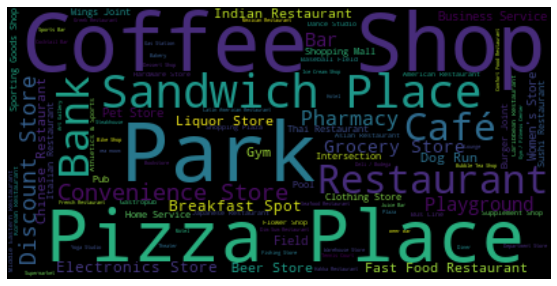

In [101]:
TO_freq=Toronto_venue[['Venue','avg_freq']]
d = {}
for a, x in TO_freq.values:
    d[a] = x
    
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [103]:
NY_venue = NY_feature.iloc[:,:-3].set_index("Borough").T.reset_index()
NY_venue = NY_venue.rename(columns={'index':'Venue'})
NY_venue["avg_freq"] = NY_venue.mean(axis = 1)
NY_venue.head()

Borough,Venue,The Bronx,Brooklyn,Manhattan,Queens,Staten Island,avg_freq
0,Accessories Store,0.002004,0.001992,0.000952,0.000000,0.000000,0.000990
1,Adult Boutique,0.000000,0.000000,0.000952,0.000000,0.000000,0.000190
2,Afghan Restaurant,0.000000,0.000000,0.000952,0.001176,0.000000,0.000426
3,African Restaurant,0.002004,0.000000,0.001905,0.000000,0.000000,0.000782
4,American Restaurant,0.004008,0.011952,0.026667,0.012941,0.016736,0.014461


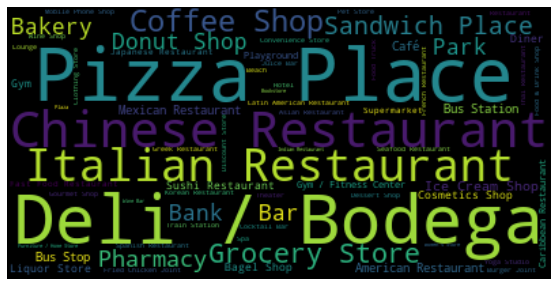

In [105]:
NY_freq=NY_venue[['Venue','avg_freq']]
d = {}
for a, x in NY_freq.values:
    d[a] = x
    
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### We can determine that "Pizza place", "sandwich place", "coffee shop", "Park", '"Grocery Store", "Bank" seem to be the most common areas, therefore we will use the frequency of the above venues in each of the borough as the input features for pairing.  

### We do not have a comparable venue in Toronto that is similar to Deli in New York, so I did not select deli into the input features. However, "Chinese Restaurant" seem to be a hot place in New York and also the top venues in specific regions in Toronto, so I will also include that into analysis.

In [131]:
common_venues = ['Pizza Place','Sandwich Place','Coffee Shop','Park','Grocery Store',"Bank",'Chinese Restaurant']
TO_feature_new = pd.concat([TO_feature[['FM_list']],TO_feature[['Population','Land area (km2)','avg_income_USD']],
                            TO_feature[common_venues]],axis = 1)
TO_feature_new = TO_feature_new.set_index('FM_list')

In [132]:
NY_feature_new = pd.concat([NY_feature[['Borough']],NY_feature[['Population','Land area (km2)','Average income']],
                            NY_feature[common_venues]],axis = 1)
NY_feature_new = NY_feature_new.set_index('Borough')

,Population,Land area (km2),Average income,Pizza Place,Sandwich Place,Coffee Shop,Park,Grocery Store,Bank,Chinese Restaurant
Borough,,,,,,,,,,
The Bronx,1418207,109.04,46298.0,0.078156,0.024048,0.010020,0.018036,0.038076,0.018036,0.036072
Brooklyn,2559903,183.42,60020.0,0.043825,0.014940,0.035857,0.011952,0.022908,0.007968,0.026892
Manhattan,1628706,59.13,121549.0,0.018095,0.020952,0.044762,0.022857,0.010476,0.004762,0.014286
Queens,2253858,281.09,67027.0,0.036471,0.009412,0.020000,0.014118,0.023529,0.028235,0.038824
Staten Island,476143,151.18,81498.0,0.062762,0.027197,0.023013,0.012552,0.020921,0.023013,0.029289


### Because the demographic data are much larger than all the frequency data, I decided to apply standard scaler to mitigate the feature influence

In [133]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
TO_feature_new[['Population', 'Land area (km2)','avg_income_USD']] = scaler.fit_transform(TO_feature_new[['Population', 'Land area (km2)','avg_income_USD']])
NY_feature_new[['Population','Land area (km2)','Average income']] = scaler.fit_transform(NY_feature_new[['Population','Land area (km2)','Average income']])


In [134]:
from sklearn.metrics.pairwise import euclidean_distances
pairing_df =pd.DataFrame(euclidean_distances(NY_feature_new,TO_feature_new))
pairing_df.index =  NY_feature_new.index
pairing_df.columns = TO_feature_new.index
pairing_df['min_distance'] = pairing_df.min(axis=1)
pairing_df['min_distance_id'] = pairing_df.idxmin(axis=1)

In [135]:
pairing_df

FM_list,Etobicoke,East York,North York,Toronto,Scarborough,York,min_distance,min_distance_id
Borough,,,,,,,,
The Bronx,1.664730,1.631196,2.456728,3.322585,2.277624,1.075990,1.075990,York
Brooklyn,1.868846,3.075152,0.974935,2.518428,1.211120,2.892508,0.974935,North York
Manhattan,2.163395,2.166866,3.224485,1.584276,4.140370,2.871253,1.584276,Toronto
Queens,1.990163,3.624257,0.627208,2.832535,1.072952,3.541983,0.627208,North York
Staten Island,1.284479,1.249745,2.905275,3.107211,3.261467,1.663754,1.249745,East York
